<a href="https://colab.research.google.com/github/cruise12343/test2/blob/master/BinanceDoge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 import json
import requests as req
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler 
%matplotlib inline

In [2]:
market = 'DOGEUSDT'
tick_interval = '1m'
limit = 1000
y =  req.get(f'https://api.binance.com/api/v3/klines?symbol={market}&interval={tick_interval}&limit={str(limit)}').json()

In [3]:
hist = pd.DataFrame(y,columns=['Open Time','Open','High','Low','Close','Volume','Close Time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','ignore'])
hist = hist.set_index('Open Time')
hist.index = pd.to_datetime(hist.index, unit='ms')
#hist['Close Time'] = pd.to_datetime(hist['Close Time'], unit='ms')
hist['Close'] = hist['Close'].apply(lambda x:float(x))

In [4]:
def train_test_split(df, test_size=0.2):    
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(hist, test_size=0.2)

In [5]:
def line_plot(line1,line2,label1=None,label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USDT]', fontsize=15)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    fig.savefig('f5.jpg',dpi=150)

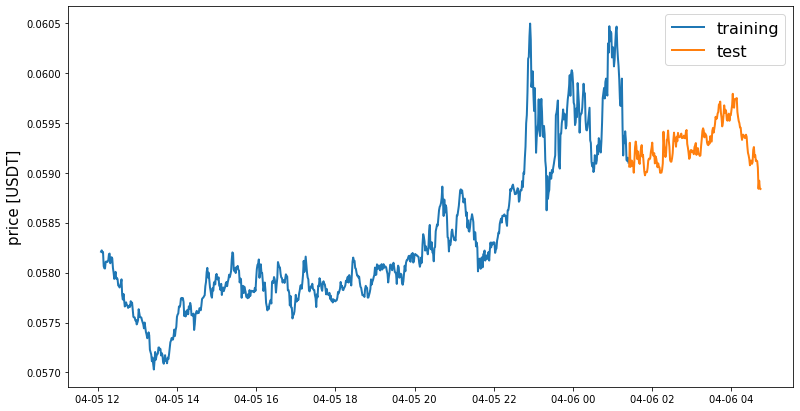

In [6]:
target_col = 'Close'
line_plot(train[target_col],test[target_col], 'training', 'test', title='')

In [7]:
#hist.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

In [8]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = MinMaxScaler().fit_transform(tmp[['Open','High','Low','Close','Volume','Close Time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','ignore']])
            #print(tmp.values)  
        window_data.append(tmp)
        #print(window_data)
    return np.array(window_data)

In [9]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
 
    return train_data, test_data, X_train, X_test, y_train, y_test

In [10]:
 def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [11]:
 np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [12]:
 
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
25/25 [==============================] - 2s 6ms/step - loss: 0.0064
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 8.4004e-04
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 6.0806e-04
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 4.8664e-04
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 3.5806e-04
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 3.4007e-04
Epoch 9/100
25/25 [==============================] - 0s 6ms/step - loss: 2.5554e-04
Epoch 10/100
25/25 [==============================] - 0s 5ms/step - loss: 2.9453e-04
Epoch 11/100
25/25 [==============================] - 0s 6ms/step - loss: 2.5059e-04
Epoch 12/100
25/25 [==============================] - 0s 6ms/step - loss: 1.9490e-04
E

In [13]:
#test.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

In [14]:
 targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.0012334391083561108

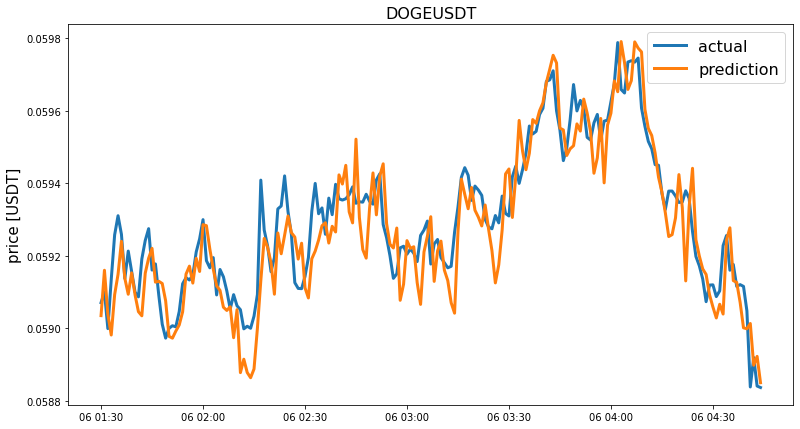

In [15]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction',market, lw=3)

In [18]:
 
#path = '/content/drive/MyDrive/DNN/DogePrediction.h5' 
#model.save('/content/drive/MyDrive/DNN/'+market+'.h5')